In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, brier_score_loss, log_loss, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
import jax.numpy as jnp
from numpyro.infer import Predictive
import jax
import numpyro
import jax.random as rand
import numpyro.distributions as dist
from sklearn.calibration import calibration_curve

In [2]:
results_dir = 'results'
log_path = f'{results_dir}/experiment_log.csv'
metrics_path = f'{results_dir}/evaluation_metrics.csv'

In [3]:
log_df = pd.read_csv(log_path)
metrics_df = pd.read_csv(metrics_path)
df = pd.merge(log_df, metrics_df, on='id', how='inner')

In [4]:
bnn_df = df[df['status'] == 'success']

In [5]:
bnn_df

,id,method,kernel,width,precision_prior,duration_seconds,status,guide,precision,recall,f1,log_loss,brier,ece
0,mcmc_NUTS_w5_p0.5,mcmc,NUTS,5,0.5,2379.41,success,NaN,0.948,0.906,0.926,0.0671,0.0194,0.0123
1,mcmc_NUTS_w5_p1.0,mcmc,NUTS,5,1.0,2431.13,success,NaN,0.959,0.900,0.928,0.0671,0.0185,0.0128
2,mcmc_NUTS_w5_p2.0,mcmc,NUTS,5,2.0,2396.50,success,NaN,0.958,0.894,0.925,0.0659,0.0183,0.0127
3,mcmc_NUTS_w10_p0.5,mcmc,NUTS,10,0.5,3743.18,success,NaN,0.966,0.933,0.949,0.0439,0.0129,0.0090
4,mcmc_NUTS_w10_p1.0,mcmc,NUTS,10,1.0,3368.19,success,NaN,0.988,0.933,0.960,0.0470,0.0128,0.0126
5,mcmc_NUTS_w10_p2.0,mcmc,NUTS,10,2.0,3265.92,success,NaN,0.965,0.922,0.943,0.0484,0.0142,0.0101
6,mcmc_NUTS_w14_p0.5,mcmc,NUTS,14,0.5,4429.14,success,NaN,0.976,0.922,0.949,0.0421,0.0127,0.0120
7,mcmc_NUTS_w14_p1.0,mcmc,NUTS,14,1.0,4595.14,success,NaN,0.961,0.950,0.955,0.0450,0.0128,0.0100
8,mcmc_NUTS_w14_p2.0,mcmc,NUTS,14,2.0,4604.65,success,NaN,0.966,0.944,0.955,0.0397,0.0119,0.0082
9,vi_AutoDiag_w5_p0.5,vi,NaN,5,0.5,18.17,success,AutoDiag,0.954,0.800,0.870,0.1157,0.0304,0.0240


In [6]:
if bnn_df.empty:
    raise ValueError('No completed BNN runs found.')

In [7]:
best_row = bnn_df.loc[bnn_df['f1'].idxmax()]

In [8]:
best_row

id                  mcmc_NUTS_w10_p1.0
method                            mcmc
kernel                            NUTS
width                               10
precision_prior                    1.0
duration_seconds               3368.19
status                         success
guide                              NaN
precision                        0.988
recall                           0.933
f1                                0.96
log_loss                         0.047
brier                           0.0128
ece                             0.0126
Name: 4, dtype: object

In [9]:
best_config = {
    'id': best_row['id'],
    'f1': best_row['f1'],
    'width': int(best_row['width']),
    'precision_prior': best_row['precision_prior'],
    'kernel': best_row['kernel'],
    'guide': best_row['guide']
}

In [10]:
print(f'Best BNN run:\n{best_config}')

Best BNN run:
{'id': 'mcmc_NUTS_w10_p1.0', 'f1': np.float64(0.96), 'width': 10, 'precision_prior': np.float64(1.0), 'kernel': 'NUTS', 'guide': nan}


In [11]:
width = best_config['width']
precision_prior = best_config['precision_prior']

In [12]:
train = pd.read_csv('data/processed/train.csv')
val = pd.read_csv('data/processed/validation.csv')

In [13]:
y_train = train['label'].values
X_train = train.drop(['label'], axis=1).values

y_val = val['label'].values
X_val = val.drop(['label'], axis=1).values

In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

## Neural Network

In [ ]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, precision):
        super().__init__()
        self.precision = precision
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()

    def _init_weights(self):
        fan_in1 = self.fc1.in_features
        std1 = np.sqrt(2.0 / (self.precision * (fan_in1 + 1)))
        nn.init.normal_(self.fc1.weight, mean=0.0, std=std1)
        nn.init.normal_(self.fc1.bias, mean=0.0, std=std1)

        fan_in2 = self.fc2.in_features
        std2 = np.sqrt(2.0 / (self.precision * (fan_in2 + 1)))
        nn.init.normal_(self.fc2.weight, mean=0.0, std=std2)
        nn.init.normal_(self.fc2.bias, mean=0.0, std=std2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [16]:
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [17]:
input_dim = X_train.shape[1]
nn_model = NN(input_dim, width, precision_prior)
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)
batch_size = 256
epochs = 20

In [18]:
nn_train_loss_history = []
nn_val_loss_history = []
nn_train_f1_history = []
nn_val_f1_history = []

In [19]:
for epoch in range(epochs):
    nn_model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = nn_model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (outputs.detach() > 0.5).long()
        all_preds.append(preds)
        all_labels.append(batch_y.long())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    train_f1 = f1_score(all_labels.cpu(), all_preds.cpu())
    train_loss = epoch_loss / (X_train_tensor.size()[0] // batch_size)

    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = (val_outputs > 0.5).long()
        val_f1 = f1_score(y_val_tensor.cpu(), val_preds.cpu())

    # Store metrics
    nn_train_loss_history.append(train_loss)
    nn_val_loss_history.append(val_loss)
    nn_train_f1_history.append(train_f1)
    nn_val_f1_history.append(val_f1)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

Epoch 1/20 - Train Loss: 0.5971, Train F1: 0.4489, Val Loss: 0.3049, Val F1: 0.8462
Epoch 2/20 - Train Loss: 0.2371, Train F1: 0.8284, Val Loss: 0.1705, Val F1: 0.8715
Epoch 3/20 - Train Loss: 0.1620, Train F1: 0.8596, Val Loss: 0.1286, Val F1: 0.8869
Epoch 4/20 - Train Loss: 0.1361, Train F1: 0.8685, Val Loss: 0.1118, Val F1: 0.8902
Epoch 5/20 - Train Loss: 0.1243, Train F1: 0.8727, Val Loss: 0.1046, Val F1: 0.8936
Epoch 6/20 - Train Loss: 0.1187, Train F1: 0.8750, Val Loss: 0.1010, Val F1: 0.8936
Epoch 7/20 - Train Loss: 0.1153, Train F1: 0.8752, Val Loss: 0.0991, Val F1: 0.8936
Epoch 8/20 - Train Loss: 0.1130, Train F1: 0.8752, Val Loss: 0.0977, Val F1: 0.8936
Epoch 9/20 - Train Loss: 0.1114, Train F1: 0.8749, Val Loss: 0.0968, Val F1: 0.8936
Epoch 10/20 - Train Loss: 0.1102, Train F1: 0.8746, Val Loss: 0.0963, Val F1: 0.8936
Epoch 11/20 - Train Loss: 0.1094, Train F1: 0.8753, Val Loss: 0.0961, Val F1: 0.8909
Epoch 12/20 - Train Loss: 0.1086, Train F1: 0.8750, Val Loss: 0.0959, Val 

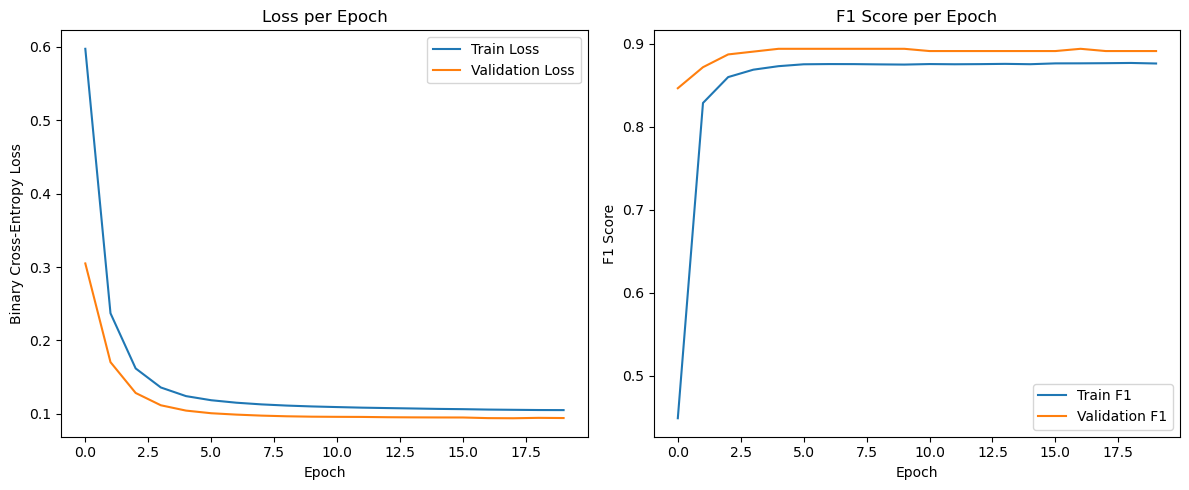

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(nn_train_loss_history, label='Train Loss')
plt.plot(nn_val_loss_history, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()

# Plotting F1 Score
plt.subplot(1, 2, 2)
plt.plot(nn_train_f1_history, label='Train F1')
plt.plot(nn_val_f1_history, label='Validation F1')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
nn_model.eval()
with torch.no_grad():
    val_outputs = nn_model(X_val_tensor).squeeze()
    val_probs = val_outputs.cpu().numpy()  # predicted probabilities
    val_preds = (val_outputs > 0.5).long().cpu().numpy()  # predicted classes
    y_val_np = y_val_tensor.cpu().numpy()  # true labels

# Compute metrics
val_log_loss = log_loss(y_val_np, val_probs)
val_brier_score = brier_score_loss(y_val_np, val_probs)
val_f1 = f1_score(y_val_np, val_preds)

print(f'Validation Log Loss: {val_log_loss:.4f}')
print(f'Validation Brier Score: {val_brier_score:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

Validation Log Loss: 0.0944
Validation Brier Score: 0.0275
Validation F1 Score: 0.8909


### Calibrated Neural Network

In [56]:
class CalibratedNN:
    def __init__(self, input_dim, hidden_dim, precision, lr=1e-3, batch_size=256, epochs=20, device='cpu'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.precision = precision
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device
        self.models = []
        self.calibrators = []

    def _init_model(self):
        model = NN(self.input_dim, self.hidden_dim, self.precision).to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        return model, optimizer

    def _train_one_model(self, model, optimizer, X_train, y_train):
        criterion = nn.BCELoss()
        model.train()
        for epoch in range(self.epochs):
            permutation = torch.randperm(X_train.size()[0])
            for i in range(0, X_train.size()[0], self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_train[indices], y_train[indices]

                optimizer.zero_grad()
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return model

    def fit(self, X_tensor, y_tensor):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
        X_np = X_tensor.cpu().numpy()
        y_np = y_tensor.cpu().numpy()

        for train_idx, cal_idx in skf.split(X_np, y_np):
            X_train, X_cal = X_tensor[train_idx], X_tensor[cal_idx]
            y_train, y_cal = y_tensor[train_idx], y_tensor[cal_idx]

            model, optimizer = self._init_model()
            model = self._train_one_model(model, optimizer, X_train, y_train)

            model.eval()
            with torch.no_grad():
                probs_cal = model(X_cal).squeeze().cpu().numpy()
                y_cal_np = y_cal.cpu().numpy()

            # Fit calibration model
            #calibrator = LogisticRegression(solver='lbfgs')
            #calibrator.fit(probs_cal.reshape(-1, 1), y_cal_np)

            calibrator = IsotonicRegression(out_of_bounds='clip')
            calibrator.fit(probs_cal, y_cal_np)

            self.models.append(model)
            self.calibrators.append(calibrator)

    def predict_proba(self, X_tensor):
        calibrated_probs = []

        for model, calibrator in zip(self.models, self.calibrators):
            model.eval()
            with torch.no_grad():
                probs = model(X_tensor.to(self.device)).squeeze().cpu().numpy()
            #probs = calibrator.predict_proba(probs.reshape(-1, 1))[:, 1]
            probs = calibrator.predict(probs)
            calibrated_probs.append(probs)

        return np.mean(calibrated_probs, axis=0)

    def predict(self, X_tensor, threshold=0.5):
        probs = self.predict_proba(X_tensor)
        return (probs > threshold).astype(int)

In [57]:
calibrated_nn = CalibratedNN(input_dim, hidden_dim=10, precision=precision_prior, epochs=20)
calibrated_nn.fit(X_train_tensor, y_train_tensor)

In [58]:
cal_probs = calibrated_nn.predict_proba(X_val_tensor)

# Predict classes
cal_preds = calibrated_nn.predict(X_val_tensor)

# Evaluate
print('Calibrated Log Loss:', log_loss(y_val_tensor.cpu().numpy(), cal_probs))
print('Calibrated Brier Score:', brier_score_loss(y_val_tensor.cpu().numpy(), cal_probs))
print('Calibrated F1 Score:', f1_score(y_val_tensor.cpu().numpy(), cal_preds))

Calibrated Log Loss: 0.0838252739814802
Calibrated Brier Score: 0.024376801357752914
Calibrated F1 Score: 0.8820224719101124


In [59]:
cal_probs = calibrated_nn.predict_proba(X_val_tensor)

# Predict classes
cal_preds = calibrated_nn.predict(X_val_tensor)

# Evaluate
print('Calibrated Log Loss:', log_loss(y_val_tensor.cpu().numpy(), cal_probs))
print('Calibrated Brier Score:', brier_score_loss(y_val_tensor.cpu().numpy(), cal_probs))
print('Calibrated F1 Score:', f1_score(y_val_tensor.cpu().numpy(), cal_preds))

Calibrated Log Loss: 0.0838252739814802
Calibrated Brier Score: 0.024376801357752914
Calibrated F1 Score: 0.8820224719101124


### XGBoost

In [60]:
gb_model = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth=3,
    subsample=0.8,
    min_samples_split=10,
    random_state=123
)

In [61]:
gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,1000
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [62]:
# Predict probabilities and classes
val_probs = gb_model.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

# Evaluate
f1 = f1_score(y_val, val_preds)
logloss = log_loss(y_val, val_probs)
brier = brier_score_loss(y_val, val_probs)

print(f'F1 Score: {f1:.4f}')
print(f'Log Loss: {logloss:.4f}')
print(f'Brier Score: {brier:.4f}')

F1 Score: 0.9661
Log Loss: 0.0304
Brier Score: 0.0087


### Calibrated XGBoost

In [92]:
calibrated_gb = CalibratedClassifierCV(
    estimator=gb_model,
    method='isotonic',  
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
)

In [93]:
calibrated_gb.fit(X_train, y_train)

,estimator,GradientBoost...subsample=0.8)
,method,'isotonic'
,cv,StratifiedKFo... shuffle=True)
,n_jobs,None
,ensemble,'auto'
,loss,'log_loss'
,learning_rate,0.1
,n_estimators,1000
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10


In [94]:
# Predict probabilities and classes on validation data
val_probs = calibrated_gb.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

# Evaluate metrics
f1 = f1_score(y_val, val_preds)
logloss = log_loss(y_val, val_probs)
brier = brier_score_loss(y_val, val_probs)

print(f'Calibrated GB - F1 Score: {f1:.4f}')
print(f'Calibrated GB - Log Loss: {logloss:.4f}')
print(f'Calibrated GB - Brier Score: {brier:.4f}')

Calibrated GB - F1 Score: 0.9748
Calibrated GB - Log Loss: 0.0297
Calibrated GB - Brier Score: 0.0083


## Benchmarking

In [95]:
test = pd.read_csv('data/processed/test.csv')

In [96]:
X_test = test.drop(['label'], axis=1).values
y_test = test['label'].values

In [97]:
def compute_ece(probabilities, true_labels, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(probabilities, bin_edges) - 1

    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            bin_confidence = probabilities[bin_mask].mean()
            bin_accuracy = true_labels[bin_mask].mean()
            ece += np.abs(bin_confidence - bin_accuracy) * bin_mask.mean()
    return ece

In [98]:
def evaluate_model(model_name, dataset_name, y_true, probs, preds, results_list):
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'log_loss',
        'value': log_loss(y_true, probs)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'brier',
        'value': brier_score_loss(y_true, probs)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'f1',
        'value': f1_score(y_true, preds)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'precision',
        'value': precision_score(y_true, preds)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'recall',
        'value': recall_score(y_true, preds)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'ece',
        'value': compute_ece(np.array(probs), np.array(y_true))
    })

#### BNN

In [99]:
best_bnn = best_row['id']

with open(f'results/bnn/{best_bnn}.pkl', 'rb') as f:
    bnn_samples = pickle.load(f)

In [100]:
X_train_jax = jnp.array(X_train)
X_val_jax = jnp.array(X_val)
X_test_jax = jnp.array(X_test)

In [ ]:
prec_prior_map = {
    0.5: (1.0, 2.0),  
    1.0: (6.0, 6.0),   
    2.0: (4.0, 2.0)   
}

In [ ]:
def bnn_model(X, y=None, hidden_dim=10, prec_level=1.0):
    n, m = X.shape
    alpha, beta = prec_prior_map[prec_level]
    prec_nn = numpyro.sample('prec_nn', dist.Gamma(alpha, beta))

    with numpyro.plate('l1_hidden', hidden_dim):
        b1 = numpyro.sample('nn_b1', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (m + 1)))))
        with numpyro.plate('l1_feat', m):
            w1 = numpyro.sample('nn_w1', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (m + 1)))))

    with numpyro.plate('l2_hidden', hidden_dim):
        w2 = numpyro.sample('nn_w2', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (hidden_dim + 1)))))
    b2 = numpyro.sample('nn_b2', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (hidden_dim + 1)))))

    hidden = jnp.maximum(X @ w1 + b1, 0)
    logits = hidden @ w2 + b2

    with numpyro.plate('data', n):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [102]:
predictive = Predictive(bnn_model, posterior_samples=bnn_samples, return_sites=['obs'], parallel=True)

In [103]:
key = rand.PRNGKey(123)

In [104]:
train_probs_samples_bnn = predictive(key, X=X_train_jax, hidden_dim=width, prec_level=precision_prior)
val_probs_samples_bnn = predictive(key, X=X_val_jax, hidden_dim=width, prec_level=precision_prior)
test_probs_samples_bnn = predictive(key, X=X_test_jax, hidden_dim=width, prec_level=precision_prior)

In [105]:
def get_mean_prediction(predictive_samples):
    # Shape: (num_samples, N)
    probs = predictive_samples['obs']
    mean_probs = jnp.mean(probs, axis=0)
    return np.array(mean_probs)

In [106]:
train_probs_bnn = get_mean_prediction(train_probs_samples_bnn)
val_probs_bnn = get_mean_prediction(val_probs_samples_bnn)
test_probs_bnn = get_mean_prediction(test_probs_samples_bnn)

In [107]:
train_preds_bnn = (train_probs_bnn > 0.5).astype(int)
val_preds_bnn = (val_probs_bnn > 0.5).astype(int)
test_preds_bnn = (test_probs_bnn > 0.5).astype(int)

In [108]:
results = []

In [109]:
evaluate_model('bnn', 'train', y_train, train_probs_bnn, train_preds_bnn, results)
evaluate_model('bnn', 'val', y_val, val_probs_bnn, val_preds_bnn, results)
evaluate_model('bnn', 'test', y_test, test_probs_bnn, test_preds_bnn, results)

### NN

In [110]:
nn_model.eval()
with torch.no_grad():
    train_probs_nn = nn_model(X_train_tensor).squeeze().cpu().numpy()
    train_preds_nn = (train_probs_nn > 0.5).astype(int)
evaluate_model('nn', 'train', y_train, train_probs_nn, train_preds_nn, results)

# Evaluate NN on val
with torch.no_grad():
    val_probs_nn = nn_model(X_val_tensor).squeeze().cpu().numpy()
    val_preds_nn = (val_probs_nn > 0.5).astype(int)
evaluate_model('nn', 'val', y_val, val_probs_nn, val_preds_nn, results)

# Evaluate NN on test
X_test = test.drop(['label'], axis=1).values
y_test = test['label'].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    test_probs_nn = nn_model(X_test_tensor).squeeze().cpu().numpy()
    test_preds_nn = (test_probs_nn > 0.5).astype(int)
evaluate_model('nn', 'test', y_test, test_probs_nn, test_preds_nn, results)

### Calibrated NN

In [111]:
train_probs_calnn = calibrated_nn.predict_proba(X_train_tensor)
train_preds_calnn = calibrated_nn.predict(X_train_tensor)
evaluate_model('calibrated_nn', 'train', y_train, train_probs_calnn, train_preds_calnn, results)

val_probs_calnn = calibrated_nn.predict_proba(X_val_tensor)
val_preds_calnn = calibrated_nn.predict(X_val_tensor)
evaluate_model('calibrated_nn', 'val', y_val, val_probs_calnn, val_preds_calnn, results)

test_probs_calnn = calibrated_nn.predict_proba(X_test_tensor)
test_preds_calnn = calibrated_nn.predict(X_test_tensor)
evaluate_model('calibrated_nn', 'test', y_test, test_probs_calnn, test_preds_calnn, results)

### XGBoost

In [112]:
train_probs_gb = gb_model.predict_proba(X_train)[:, 1]
train_preds_gb = (train_probs_gb > 0.5).astype(int)
evaluate_model('gb', 'train', y_train, train_probs_gb, train_preds_gb, results)

val_probs_gb = gb_model.predict_proba(X_val)[:, 1]
val_preds_gb = (val_probs_gb > 0.5).astype(int)
evaluate_model('gb', 'val', y_val, val_probs_gb, val_preds_gb, results)

test_probs_gb = gb_model.predict_proba(X_test)[:, 1]
test_preds_gb = (test_probs_gb > 0.5).astype(int)
evaluate_model('gb', 'test', y_test, test_probs_gb, test_preds_gb, results)

### Calibrate XGBoost

In [113]:
train_probs_calgb = calibrated_gb.predict_proba(X_train)[:, 1]
train_preds_calgb = (train_probs_calgb > 0.5).astype(int)
evaluate_model('calibrated_gb', 'train', y_train, train_probs_calgb, train_preds_calgb, results)

val_probs_calgb = calibrated_gb.predict_proba(X_val)[:, 1]
val_preds_calgb = (val_probs_calgb > 0.5).astype(int)
evaluate_model('calibrated_gb', 'val', y_val, val_probs_calgb, val_preds_calgb, results)

test_probs_calgb = calibrated_gb.predict_proba(X_test)[:, 1]
test_preds_calgb = (test_probs_calgb > 0.5).astype(int)
evaluate_model('calibrated_gb', 'test', y_test, test_probs_calgb, test_preds_calgb, results)

In [114]:
results_df = pd.DataFrame(results)
results_df.to_csv('results/final_model_comparison.csv', index=False)

In [115]:
print(results_df.head())

  model dataset     metric     value
0   bnn   train   log_loss  0.056290
1   bnn   train      brier  0.014768
2   bnn   train         f1  0.945088
3   bnn   train  precision  0.969128
4   bnn   train     recall  0.922211


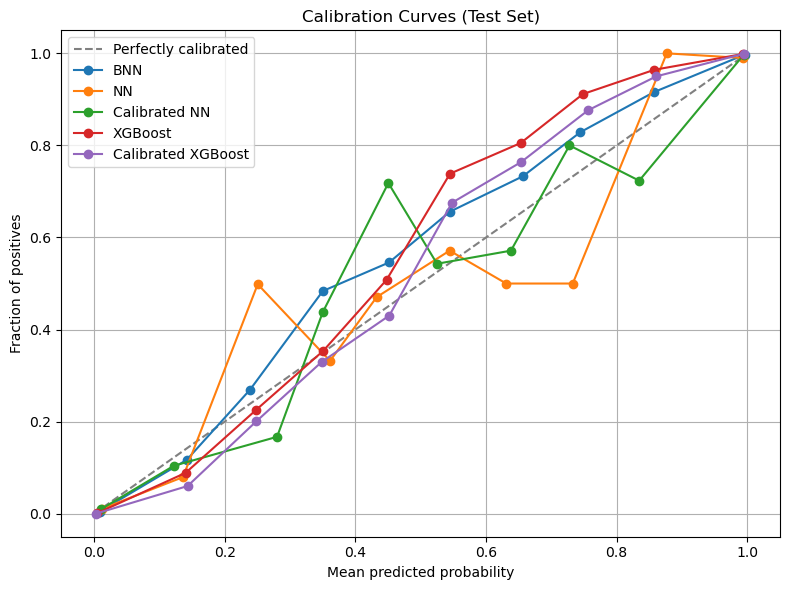

In [116]:
calibration_data = {
    'BNN': (test_probs_bnn, y_test),
    'NN': (test_probs_nn, y_test),
    'Calibrated NN': (test_probs_calnn, y_test),
    'XGBoost': (test_probs_gb, y_test),
    'Calibrated XGBoost': (test_probs_calgb, y_test),
}

plt.figure(figsize=(8, 6))

# Plot perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Loop through models
for model_name, (probs, y_true) in calibration_data.items():
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Format the plot
plt.title('Calibration Curves (Test Set)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()


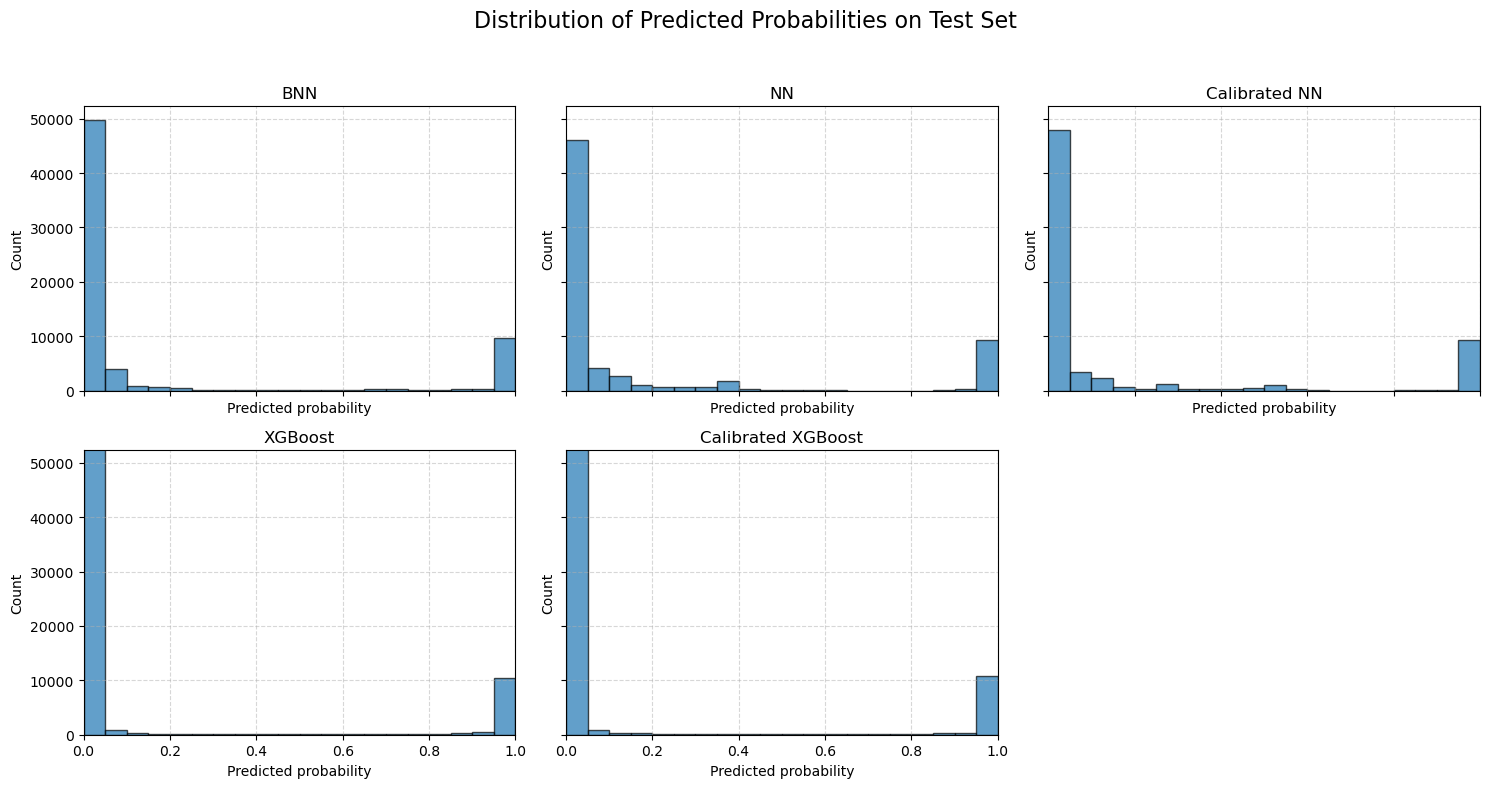

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

calibration_data = {
    'BNN': test_probs_bnn,
    'NN': test_probs_nn,
    'Calibrated NN': test_probs_calnn,
    'XGBoost': test_probs_gb,
    'Calibrated XGBoost': test_probs_calgb
}

bins = np.linspace(0, 1, 21)

for ax, (model_name, probs) in zip(axes.flat, calibration_data.items()):
    ax.hist(probs, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(model_name)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, None)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Count')
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide unused subplot if number of models < 6
if len(calibration_data) < len(axes.flat):
    for ax in axes.flat[len(calibration_data):]:
        ax.axis('off')

fig.suptitle('Distribution of Predicted Probabilities on Test Set', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

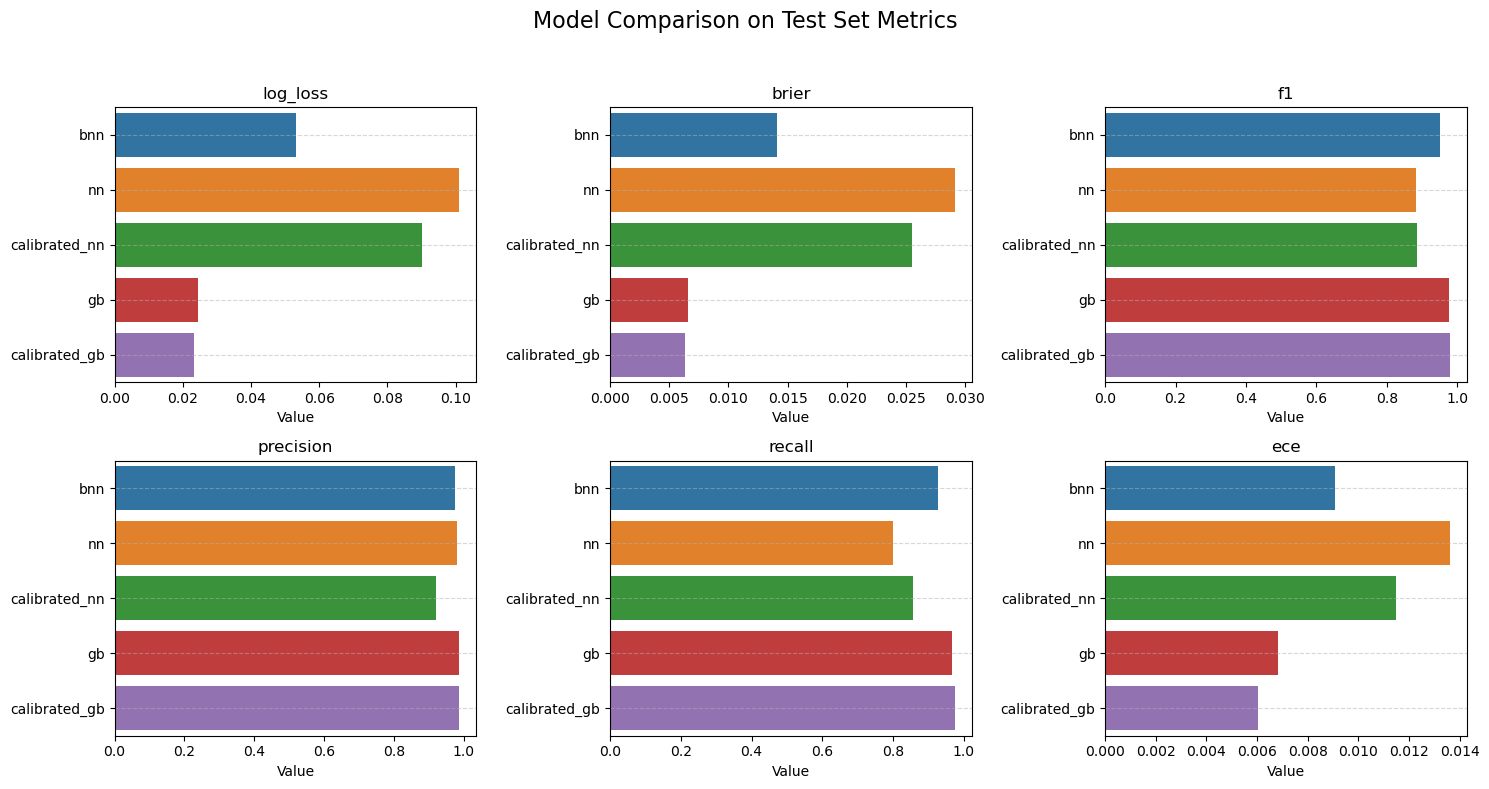

In [118]:
import seaborn as sns

metrics = results_df['metric'].unique()
n_metrics = len(metrics)

# Create subplots
ncols = 3
nrows = (n_metrics + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=False)

# Plot each metric
for ax, metric in zip(axes.flat, metrics):
    sns.barplot(data=results_df[results_df['metric'] == metric],
                y='model', x='value', ax=ax, hue='model', errorbar=None)
    ax.set_title(metric)
    ax.set_ylabel('')
    ax.set_xlabel('Value')
    ax.tick_params(axis='x')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Hide any unused axes
for i in range(n_metrics, nrows * ncols):
    axes.flat[i].set_visible(False)

fig.suptitle('Model Comparison on Test Set Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()